#### <b>Đề bài:</b> Hãy sử dụng dữ liệu được cung cấp (dữ liệu giá và khối lượng của một vài mã cổ phiếu) để xây dựng một số mô hình dự đoán biến động giá cổ phiếu. Bạn hãy phân tích và tìm mô hình dự đoán biến động giá

```
Biến động giá cổ phiếu = Giá cổ phiếu N (phút hoặc giờ hoặc ngày) sau - Giá cổ phiếu hiện tại
```

In [1]:
# Base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from os import path
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn as nn

c:\Users\Hi\anaconda3\envs\all\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preparation & Exploratory Data Analysis

In [16]:
# Read data
fpt = pd.read_csv('FPT.csv')
msn = pd.read_csv('MSN.csv')
pnj = pd.read_csv('PNJ.csv')
vic = pd.read_csv('VIC.csv')

# Since 4 of these make the same column, I'll make FPT datasets as an example
fpt.head(10)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
5,FPT,12/25/2018 9:20,30.74,30.74,30.70,30.74,7140,0
6,FPT,12/25/2018 9:21,30.66,30.74,30.59,30.66,16480,0
7,FPT,12/26/2018 9:15,31.04,31.11,31.04,31.11,2650,0
8,FPT,12/26/2018 9:16,31.19,31.19,31.19,31.19,500,0
9,FPT,12/26/2018 9:17,31.11,31.19,31.11,31.19,510,0


In [3]:
# Convert Date/Time to datetime format and set as index
fpt['Date/Time'] = pd.to_datetime(fpt['Date/Time'])
fpt.set_index('Date/Time', inplace=True)

# Remove Open Interest
fpt = fpt.drop('Open Interest', axis=1)

# Summary statistics
fpt.describe()

,Open,High,Low,Close,Volume
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06


In [4]:
# Gộp dữ liệu theo ngày và tính tổng các cột số liệu cần thiết (ví dụ: Volume)
df = fpt.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    #'Open Interest': 'sum'  # Nếu có cột này
}).reset_index()

# Xem kết quả gộp
df = df.dropna()
df.to_csv('df_fpt.csv', index=False)
df

,Date/Time,Open,High,Low,Close,Volume
0,2018-12-25,30.89,30.89,30.59,30.66,84960
1,2018-12-26,31.04,31.22,30.89,30.89,333590
2,2018-12-27,31.41,31.52,31.19,31.19,454860
3,2018-12-28,31.34,31.49,31.19,31.49,387170
8,2019-01-02,31.19,31.45,30.70,30.74,459120
...,...,...,...,...,...,...
722,2020-12-16,57.20,57.50,57.00,57.10,1995530
723,2020-12-17,56.90,57.00,56.00,56.50,3594500
724,2020-12-18,56.50,57.00,56.50,56.90,1532820
727,2020-12-21,57.30,57.80,57.10,57.50,2307390


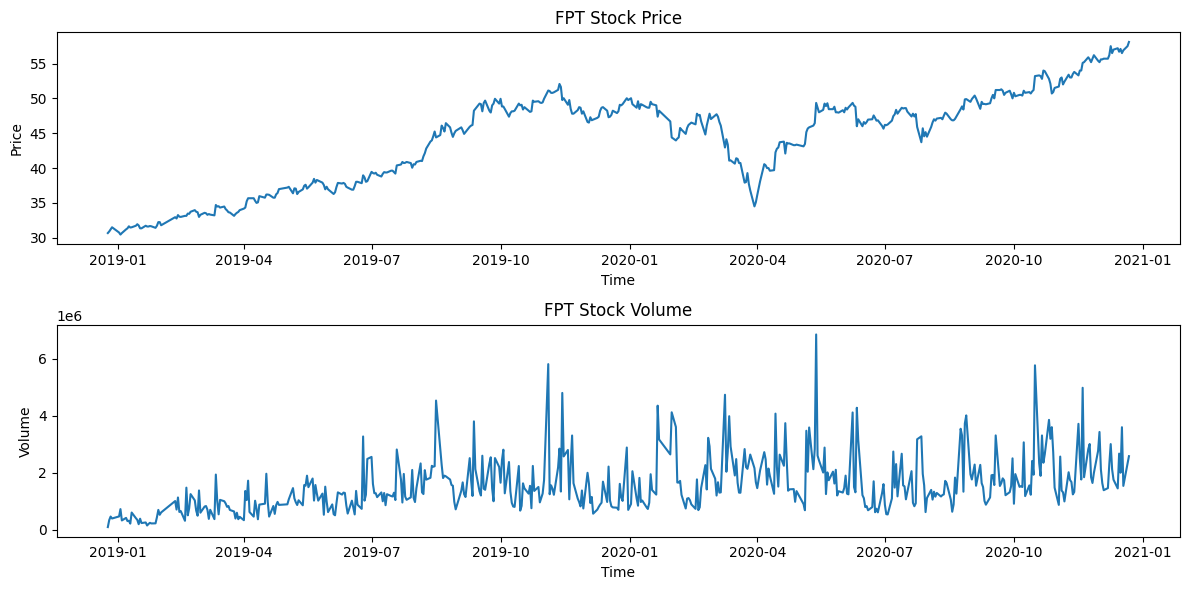

In [5]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

# Plot the price and volume
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df['Close'])
plt.title('FPT Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')

plt.subplot(2, 1, 2)
plt.plot(df['Volume'])
plt.title('FPT Stock Volume')
plt.xlabel('Time')
plt.ylabel('Volume')

plt.tight_layout()
plt.show()

### Model & Evaluation

There are many types of model which can use to predict the price fluctuation of the stock. However, we will break down only using <b>Long Short-Term Memory (LSTM) Neural Network</b>

In [17]:
# Doc du lieu FPT
dataset = fpt
train_size = int(0.7 * len(df))
dataset_train, dataset_test = df[:train_size], df[train_size:]
training_set = dataset_train.iloc[:, 3:4].values

# Thuc hien scale du lieu gia ve khoang 0,1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Tao du lieu train, X = 60 time steps, Y =  1 time step
X_train = []
y_train = []
no_of_sample = len(training_set)

for i in range(60, no_of_sample):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# Xay dung model LSTM
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Neu ton tai file model thi load
if path.exists("lstm_model.h5"):
    regressor.load_weights("lstm_model.h5")
else:
    # Con khong thi train
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save("lstm_model.h5")

Epoch 1/100
10/10 [==============================] - 6s 40ms/step - loss: 0.2066
Epoch 2/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0322
Epoch 3/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0258
Epoch 4/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0214
Epoch 5/100
10/10 [==============================] - 0s 38ms/step - loss: 0.0204
Epoch 6/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0197
Epoch 7/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0201
Epoch 8/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0184
Epoch 9/100
10/10 [==============================] - 0s 38ms/step - loss: 0.0213
Epoch 10/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0236
Epoch 11/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0210
Epoch 12/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0186
Epoch 13/100
10/10 [=====

c:\Users\Hi\anaconda3\envs\all\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 1s 16ms/step


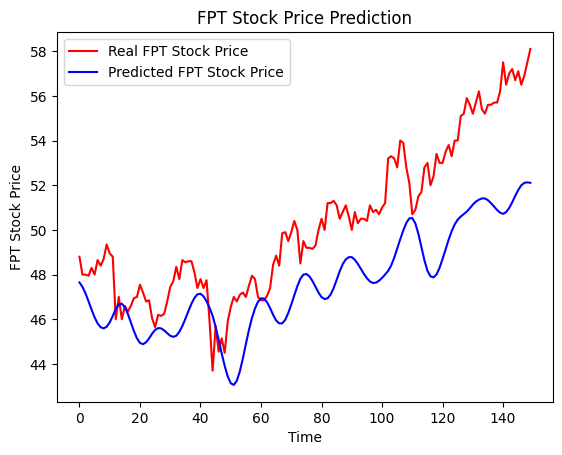

In [18]:
# Load du lieu tu PNJ
real_stock_price = dataset_test.iloc[:, 3:4].values

# Tien hanh du doan
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
no_of_sample = len(inputs)

for i in range(60, no_of_sample):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Ve bieu do gia that va gia du doan
plt.plot(real_stock_price, color = 'red', label = 'Real FPT Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted FPT Stock Price')
plt.title('FPT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()

In [15]:
dataset_test = dataset_test['Close'][len(dataset_test)-60:len(dataset_test)].to_numpy()
dataset_test = np.array(dataset_test)

inputs = dataset_test
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)


i = 0
while i<60:
    X_test = []
    no_of_sample = len(dataset_test)

    # Lay du lieu cuoi cung
    X_test.append(inputs[no_of_sample - 60:no_of_sample, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Du doan gia
    predicted_stock_price = regressor.predict(X_test)

    # chuyen gia tu khoang (0,1) thanh gia that
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    # Them ngay hien tai vao
    dataset_test = np.append(dataset_test, predicted_stock_price[0], axis=0)
    inputs = dataset_test
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    print('Stock price ' + str(i+3), predicted_stock_price[0][0])
    i = i+1

1/1 [==============================] - 0s 84ms/step
Stock price 3 54.638676
1/1 [==============================] - 0s 35ms/step
Stock price 4 54.535557
1/1 [==============================] - 0s 44ms/step
Stock price 5 54.278187
1/1 [==============================] - 0s 73ms/step
Stock price 6 53.875378
1/1 [==============================] - 0s 37ms/step
Stock price 7 53.370094
1/1 [==============================] - 0s 54ms/step
Stock price 8 52.813934
1/1 [==============================] - 0s 57ms/step
Stock price 9 52.252884
1/1 [==============================] - 0s 40ms/step
Stock price 10 51.721916
1/1 [==============================] - 0s 43ms/step
Stock price 11 51.24447
1/1 [==============================] - 0s 49ms/step
Stock price 12 50.83419
1/1 [==============================] - 0s 43ms/step
Stock price 13 50.497326
1/1 [==============================] - 0s 59ms/step
Stock price 14 50.235058
1/1 [==============================] - 0s 38ms/step
Stock price 15 50.04517
1/1 [====